In [ ]:
!pip install rectools==0.2.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 86 kB 2.5 MB/s 
     |████████████████████████████████| 13.4 MB 51.0 MB/s 
     |████████████████████████████████| 310 kB 68.3 MB/s 
     |████████████████████████████████| 88 kB 6.4 MB/s 
     |████████████████████████████████| 1.1 MB 48.5 MB/s 
     |████████████████████████████████| 60 kB 8.4 MB/s 
     |████████████████████████████████| 188 kB 62.5 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp38-cp38-linux_x86_64.whl size=3825505 sha256=35b8c6ee7e1b69534cc67d4a498b71aefdc0c91a2b4b2c7f5186e648f617e936
  Stored in directory: /root/.cache/pip/wheels/00/ac/67/6f4536c819ed560c2c7e17c0f7a920e3e50c26108616087d05
  Created wheel for lightfm: filename=lightfm-1.16-cp38-cp38-linux_x86_64.whl size=746161 sha256=f59dc37335b9f0f65ba7ed9d25f21b83d411f124659d1c5d862df7ca93d4470e
  Stored in directory: /root/.cache/pip/wheels/ec/bb/51/9c487d021

In [1]:
import requests

import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from rectools import Columns
from rectools.model_selection import TimeRangeSplit
from rectools.metrics import Precision, Recall, MeanInvUserFreq, Serendipity, MAP, calc_metrics
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender
from tqdm.auto import tqdm

from userknn import UserKnn

ModuleNotFoundError: No module named 'rectools'

In [ ]:
# calculate several classic (precision@k and recall@k) and "beyond accuracy" metrics
metrics = {
    "prec@10": Precision(k=10),
    "recall@10": Recall(k=10),
    "map@10": MAP(k=10),
    "novelty": MeanInvUserFreq(k=10),
    "serendipity": Serendipity(k=10),
}

# few simple models to compare
models = {
    "cosine": CosineRecommender(),
    "tfidf": TFIDFRecommender(),
    "bm25": BM25Recommender(K1=15, B=19.5)
}

In [ ]:
# download dataset by chunks
url = "https://storage.yandexcloud.net/itmo-recsys-public-data/kion_train.zip"

req = requests.get(url, stream=True)

with open('kion_train.zip', "wb") as fd:
    total_size_in_bytes = int(req.headers.get('Content-Length', 0))
    progress_bar = tqdm(desc='kion dataset download', total=total_size_in_bytes, unit='iB', unit_scale=True)
    for chunk in req.iter_content(chunk_size=2 ** 20):
        progress_bar.update(len(chunk))
        fd.write(chunk)

kion dataset download:   0%|          | 0.00/78.8M [00:00<?, ?iB/s]

In [ ]:
!unzip kion_train.zip

Archive:  kion_train.zip
   creating: kion_train/
  inflating: kion_train/interactions.csv  
  inflating: __MACOSX/kion_train/._interactions.csv  
  inflating: kion_train/users.csv    
  inflating: __MACOSX/kion_train/._users.csv  
  inflating: kion_train/items.csv    
  inflating: __MACOSX/kion_train/._items.csv  


Для определение оптимального кол-ва K соседей, при котором достиагется маскмальное значение метрик, код обучения был перестроен таким образом, чтобы запоминать значение метрик при различных значениях К, на каждой итерации кросс-валидации

Была написана функция read_data, представленная ниже - её задача прочитать набор данных из файла и вернуть его чать (10, 20 и т.д. процентов). Она была написана для того, чтобы иметь возможность использовать меньший объем данных во время тестирования, и обучение занимало не так много времени.

In [ ]:
def read_data(per: float):
    interactions = pd.read_csv('kion_train/interactions.csv')
    users = pd.read_csv('kion_train/users.csv')
    items = pd.read_csv('kion_train/items.csv')

    interactions.rename(columns={'last_watch_dt': Columns.Datetime,
                              'total_dur': Columns.Weight}, 
                      inplace=True) 

    interactions['datetime'] = pd.to_datetime(interactions['datetime'])
    interactions = interactions.sample(frac = per)
    return interactions

In [ ]:
results = [] #результаты всех моделей

for i in range(1, 4, 1):

    interactions = read_data(i / 10)

    n_folds = 1
    unit = "D"
    n_units = 5

    last_date = interactions[Columns.Datetime].max().normalize()
    start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  
    print(f"Start date and last date of the test fold: {start_date, last_date}")

    periods = n_folds + 1
    freq = f"{n_units}{unit}"
    print(
      f"start_date: {start_date}\n"
      f"last_date: {last_date}\n"
      f"periods: {periods}\n"
      f"freq: {freq}\n"
    )

    date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
    print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

    # generator of folds
    cv = TimeRangeSplit(
      date_range=date_range,
      filter_already_seen=True,
      filter_cold_items=True,
      filter_cold_users=True,
    )
    print(f"Real number of folds: {cv.get_n_splits(interactions)}")

    per_results = []
    fold_iterator = cv.split(interactions, collect_fold_stats=True)

    for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
        print(f"\n==================== Fold {i_fold}")
        print(fold_info)

        df_train = interactions.iloc[train_ids].copy()
        df_test = interactions.iloc[test_ids][Columns.UserItem].copy()

        catalog = df_train[Columns.Item].unique()

        for model_name, model in models.items():
            for n in range(10, 65, 5):
                userknn_model = UserKnn(model=model, N_users=n)
                userknn_model.fit(df_train)

                recos = userknn_model.predict(df_test)

                metric_values = calc_metrics(
                    metrics,
                    reco=recos,
                    interactions=df_test,
                    prev_interactions=df_train,
                    catalog=catalog,
                )

                fold = {"per": i/10, "fold": i_fold, "k": n, "model": model_name}
                fold.update(metric_values)
                print(fold)
                per_results.append(fold)
            results.append(per_results)

Start date and last date of the test fold: (Timestamp('2021-08-16 00:00:00'), Timestamp('2021-08-22 00:00:00'))
start_date: 2021-08-16 00:00:00
last_date: 2021-08-22 00:00:00
periods: 2
freq: 5D

Test fold borders: ['2021-08-16' '2021-08-21']
Real number of folds: 1

==================== Fold 0
{'Start date': Timestamp('2021-08-16 00:00:00', freq='5D'), 'End date': Timestamp('2021-08-21 00:00:00', freq='5D'), 'Train': 5051815, 'Train users': 906071, 'Train items': 15577, 'Test': 207727, 'Test users': 85168, 'Test items': 6109}


  0%|          | 0/906071 [00:00<?, ?it/s]

{'model_name': 'cosine', 'model': <__main__.UserKnn object at 0x7f324e1f9a00>, 'prec@10': 0.0029999530340033814, 'recall@10': 0.016337850082903622, 'map@10': 0.002927372940549914, 'novelty': 8.314817115428983, 'serendipity': 4.7560958940661814e-05}


  0%|          | 0/906071 [00:00<?, ?it/s]

{'model_name': 'tfidf', 'model': <__main__.UserKnn object at 0x7f324456c1f0>, 'prec@10': 0.005197961675746759, 'recall@10': 0.028708677507013208, 'map@10': 0.005516857740274315, 'novelty': 8.240146930593266, 'serendipity': 5.951310880619221e-05}


  0%|          | 0/906071 [00:00<?, ?it/s]

{'model_name': 'bm25', 'model': <__main__.UserKnn object at 0x7f323ae1ed90>, 'prec@10': 0.0006058613563779823, 'recall@10': 0.0022446922136746673, 'map@10': 0.0005152807530598287, 'novelty': 11.192535619141902, 'serendipity': 8.376194565901258e-05}


Для получения значения метрик и определения K было выполнено обучение моделей на 10%, 20% и 30% объема обучающей выборки. Графики, полученные ниже, иллюстрируют, что оптимальным значением K является 20. Тенденции роста оптимального значения К с увеличением объема данных не выявлено. 

In [ ]:
#код, позволяющий сохранить полученные значения в файл 
for i in range(len(results)):
    results_i = pd.DataFrame(results[i]).drop(columns="fold").groupby(["k"], sort=False).agg("mean")
    print(results_i)
    results_i.to_csv('results_bm25_{}.csv'.format(i), index=False)

    per   prec@10  recall@10    map@10
k                                     
10  0.1  0.000077   0.000577  0.000362
15  0.1  0.000136   0.001053  0.000579
20  0.1  0.000175   0.001399  0.000711
25  0.1  0.000175   0.001399  0.000711
30  0.1  0.000175   0.001399  0.000711
35  0.1  0.000175   0.001399  0.000711
40  0.1  0.000175   0.001399  0.000711
45  0.1  0.000175   0.001399  0.000711
50  0.1  0.000175   0.001399  0.000711
55  0.1  0.000175   0.001399  0.000711
60  0.1  0.000175   0.001399  0.000711


In [ ]:
#выполним построения графиков, для того, чтобы наглядно отразить результаты экспериментов
cosine_10 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_cosine_0.csv')
cosine_20 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_cosine_1.csv')
cosine_30 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_cosine_2.csv')
tfidf_10 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_tfidf_0.csv')
tfidf_20 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_tfidf_1.csv')
tfidf_30 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_tfidf_2.csv')

cosine= pd.concat((cosine_10, cosine_20, cosine_30))
cosine_mean = cosine.drop(columns="per").groupby(cosine.index, sort=False).agg("mean")
cosine_mean.set_index([cosine_mean.index*5 + 10], inplace=True, drop=True)

tfidf = pd.concat((tfidf_10, tfidf_20, tfidf_30))
tfidf_mean = tfidf.drop(columns="per").groupby(tfidf.index, sort=False).agg("mean")
tfidf_mean.set_index([tfidf_mean.index*5 + 10], inplace=True, drop=True)

     prec@10  recall@10    map@10   novelty  serendipity
10  0.000444   0.003362  0.000725  9.327008     0.000007
15  0.000592   0.004517  0.000899  9.440459     0.000009
20  0.000655   0.004972  0.000958  9.539425     0.000010
25  0.000655   0.004972  0.000958  9.539425     0.000010
30  0.000655   0.004972  0.000958  9.539425     0.000010
35  0.000655   0.004972  0.000958  9.539425     0.000010
40  0.000655   0.004972  0.000958  9.539425     0.000010
45  0.000655   0.004972  0.000958  9.539425     0.000010
50  0.000655   0.004972  0.000958  9.539425     0.000010
55  0.000655   0.004972  0.000958  9.539425     0.000010
60  0.000655   0.004972  0.000958  9.539425     0.000010
     prec@10  recall@10    map@10   novelty  serendipity
10  0.000703   0.005301  0.001169  9.656965     0.000006
15  0.000942   0.007192  0.001501  9.468444     0.000008
20  0.001136   0.008621  0.001776  9.359574     0.000009
25  0.001136   0.008621  0.001776  9.359574     0.000009
30  0.001136   0.008621  0.0017

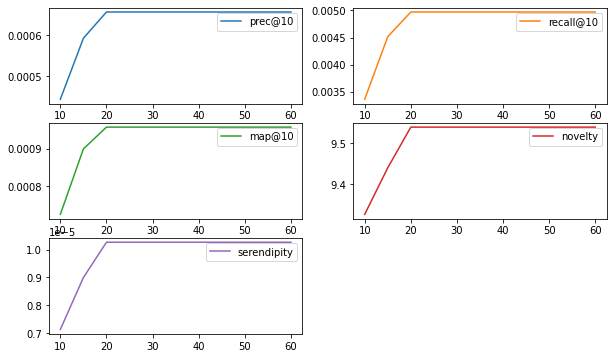

In [ ]:
cosine_mean.plot(subplots=True, layout=(3, 2), figsize=(10, 6), sharex=False);

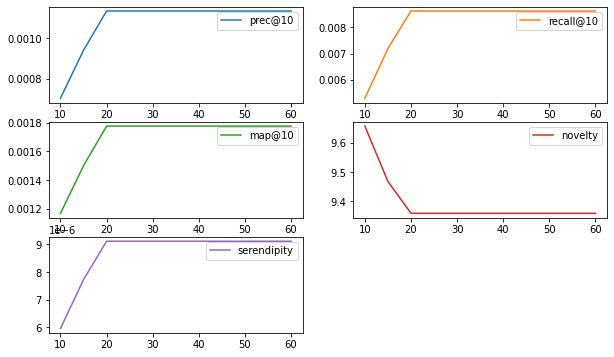

In [ ]:
tfidf_mean.plot(subplots=True, layout=(3, 2), figsize=(10, 6), sharex=False);

На графиках выше вы можете видеть результаты только для моделей cosine и tfidf, так как в процеесе проведения экспериментов была обнаружена проблема - модель bm25 имеет больше гиперпараметров, из-за чего метрики, без дополнительной настройки параметров К1 и B отображаются как 0.0. В результате этого, было принято решение проверить гипотезу об оптимальном К в 20 на малом наборе данных (10%) и случайных параметрах K1 и B при которых значения метрик хоть как-то вычисляются. Гипотеза подтвердилась. Графики представлены ниже. Теперь необходимо подобрать параметры K1 и B при K=20. Затем сравним значение метрик и выберем лучшую модель, которую в последствии обучим на 100% данных.

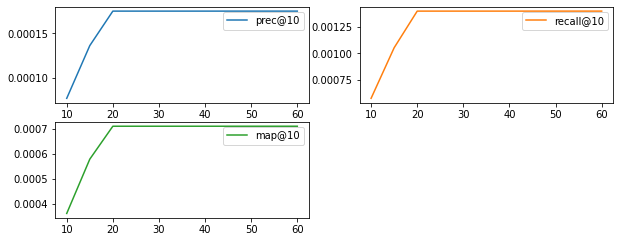

In [ ]:
bm25_10 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_bm25_0.csv')
bm25_10 = bm25_10.drop(columns="per")
bm25_10.set_index([bm25_10.index*5 + 10], inplace=True, drop=True)

bm25_10.plot(subplots=True, layout=(3, 2), figsize=(10, 6), sharex=False);

Ниже представлен абсолютно такой же процесс кросс-валидации с подбром гиперпараметров, как и выше, только модифицированный под текущую задачу.

Для ускорения процесса было принято решение выполнить запуск кода ниже несколько раз с различными границами интервалов для параметров. На первой итерации были взяты k от 1 до 100 с шагом 5 и b от 1 до 30 с шагом 2, по результатам оптимальными стали k - 16, b - 19. На втором этапе были взяты k от 14 до 16 с шагом 1 и b от 18 до 19.5 с шагом 0.5, по результатам оптимальными k1 - 15, b - 19.5

In [ ]:
interactions = read_data(0.1)

n_folds = 1
unit = "D"
n_units = 5

last_date = interactions[Columns.Datetime].max().normalize()
start_date = last_date - pd.Timedelta(n_folds * n_units + 1, unit=unit)  
print(f"Start date and last date of the test fold: {start_date, last_date}")

periods = n_folds + 1
freq = f"{n_units}{unit}"
print(
    f"start_date: {start_date}\n"
    f"last_date: {last_date}\n"
    f"periods: {periods}\n"
    f"freq: {freq}\n"
)
    
date_range = pd.date_range(start=start_date, periods=periods, freq=freq, tz=last_date.tz)
print(f"Test fold borders: {date_range.values.astype('datetime64[D]')}")

# generator of folds
cv = TimeRangeSplit(
    date_range=date_range,
    filter_already_seen=True,
    filter_cold_items=True,
    filter_cold_users=True,
)
print(f"Real number of folds: {cv.get_n_splits(interactions)}")

fold_iterator = cv.split(interactions, collect_fold_stats=True)
results = []

for i_fold, (train_ids, test_ids, fold_info) in enumerate(fold_iterator):
    print(f"\n==================== Fold {i_fold}")
    print(fold_info)

    df_train = interactions.iloc[train_ids].copy()
    df_test = interactions.iloc[test_ids][Columns.UserItem].copy()

    catalog = df_train[Columns.Item].unique()
    
    for k_1 in range(14, 17, 1):
        for b in [x / 10.0 for x in range(180, 200, 5)]:
            model = UserKnn(model=BM25Recommender(K1=15, B=19.5), N_users=20)
            model.fit(df_train)

            recos = model.predict(df_test)

            metric_values = calc_metrics(
                metrics,
                reco=recos,
                interactions=df_test,
                prev_interactions=df_train,
                catalog=catalog,
            )

            fold = {"fold": i_fold}
            fold.update(metric_values)
            print(fold)
            results.append(fold)

Start date and last date of the test fold: (Timestamp('2021-08-16 00:00:00'), Timestamp('2021-08-22 00:00:00'))
start_date: 2021-08-16 00:00:00
last_date: 2021-08-22 00:00:00
periods: 2
freq: 5D

Test fold borders: ['2021-08-16' '2021-08-21']
Real number of folds: 1

==================== Fold 0
{'Start date': Timestamp('2021-08-16 00:00:00', freq='5D'), 'End date': Timestamp('2021-08-21 00:00:00', freq='5D'), 'Train': 505431, 'Train users': 287050, 'Train items': 9688, 'Test': 12155, 'Test users': 9886, 'Test items': 2612}


  0%|          | 0/287050 [00:00<?, ?it/s]

{'fold': 0, 'prec@10': 0.00034392069593364356, 'recall@10': 0.002608065277496797, 'map@10': 0.0007591704157554855, 'novelty': 9.630624983012384, 'serendipity': 1.2964084303993072e-05}


После получения значения гиперпараметров было произведено "обучение" bm25 на 30% данных.
Затем мы сравнили значения метрик каждой модели и приняли решение, что tfidf становится основной

In [ ]:
bm25 = pd.read_csv('/content/drive/MyDrive/recsys/hw3/hyp_opt/results_bm25.csv', index_col=0)
cosine = cosine_30.iloc[2].drop('per')
tfidf = tfidf_30.iloc[2].drop('per')

print("cosine\n", cosine, "\n")
print("tfidf\n", tfidf, "\n")
print("bm25\n", bm25, "\n")

cosine
 prec@10        0.000956
recall@10      0.007010
map@10         0.001310
novelty        9.040109
serendipity    0.000013
Name: 2, dtype: float64 

tfidf
 prec@10        0.001781
recall@10      0.013013
map@10         0.002612
novelty        8.862508
serendipity    0.000013
Name: 2, dtype: float64 

bm25
                      0
prec@10       0.000778
recall@10     0.005509
map@10        0.001030
novelty      10.857291
serendipity   0.000031 

